## 03 — Clustering + Summarization
Goal: cluster reviews into themes and generate short summaries + representative examples.  

In [2]:
import pandas as pd

use = pd.read_csv("../data/processed/test_labeled.csv")
use.shape, use.columns

((6926, 4),
 Index(['text', 'label', 'pred_label', 'pred_confidence'], dtype='str'))

In [4]:
import pandas as pd

df = pd.read_csv("../data/processed/test_labeled.csv")
df = df.dropna(subset=["text", "pred_label"]).copy()

df[["pred_label"]].value_counts()

pred_label
2             6630
1              158
0              138
Name: count, dtype: int64

## Create text embeddings
We embed each review so clustering groups by meaning instead of keywords.

In [3]:
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
texts = use["text"].astype(str).tolist()

emb = embedder.encode(texts, batch_size=64, show_progress_bar=True, normalize_embeddings=True)
emb.shape

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Batches:   0%|          | 0/109 [00:00<?, ?it/s]

(6926, 384)

## Reduce dimensions (UMAP)
UMAP helps clusters separate more cleanly and gives us a 2D view for plotting.

In [6]:
use = df.dropna(subset=["text"]).copy().reset_index(drop=True)
use.shape, use["pred_label"].value_counts()

((6926, 4),
 pred_label
 2    6630
 1     158
 0     138
 Name: count, dtype: int64)

In [ ]:
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
texts = use["text"].astype(str).tolist()

emb = embedder.encode(texts, batch_size=64, show_progress_bar=True, normalize_embeddings=True)
emb.shape

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Batches:   0%|          | 0/109 [00:00<?, ?it/s]

(6926, 384)

In [8]:
import umap

um = umap.UMAP(n_neighbors=25, min_dist=0.1, metric="cosine", random_state=42)
emb_2d = um.fit_transform(emb)

emb_2d.shape

/home/lopoa/projects/automated-customer-reviews/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(6926, 2)

## Cluster reviews (HDBSCAN)
Now that we have embeddings (and UMAP for visualization), we cluster reviews into themes.

In [9]:
import hdbscan

use = df.dropna(subset=["text", "pred_label"]).copy().reset_index(drop=True)
use["cluster_id"] = -1

for label, mcs, ms in [(0, 5, 2), (1, 6, 2), (2, 12, 5)]:
    part = use[use["pred_label"] == label]
    if len(part) < mcs:
        continue

    idx = part.index.to_numpy()
    X = emb[idx]

    cl = hdbscan.HDBSCAN(min_cluster_size=mcs, min_samples=ms, metric="euclidean")
    use.loc[idx, "cluster_id"] = cl.fit_predict(X)

use[["pred_label", "cluster_id"]].value_counts().head(15)

pred_label  cluster_id
2           -1            5072
             4             988
             3             349
             2             113
1            0              92
0            0              81
2            5              68
1           -1              58
0           -1              52
2            0              24
             1              16
1            1               8
0            1               5
Name: count, dtype: int64

In [10]:
id2label = {0: "negative", 1: "neutral", 2: "positive"}
use["pred_label_str"] = use["pred_label"].map(id2label)
use[["pred_label_str", "cluster_id"]].value_counts().head(15)

pred_label_str  cluster_id
positive        -1            5072
                 4             988
                 3             349
                 2             113
neutral          0              92
negative         0              81
positive         5              68
neutral         -1              58
negative        -1              52
positive         0              24
                 1              16
neutral          1               8
negative         1               5
Name: count, dtype: int64

## Representative reviews (per sentiment + cluster)
We pick a few “most central” reviews for each cluster so each theme has examples.

In [13]:
import numpy as np
from sklearn.metrics.pairwise import cosine_distances

rows = []
for (sent, cid), g in use[use["cluster_id"] >= 0].groupby(["pred_label_str", "cluster_id"]):
    idx = g.index.to_numpy()
    X = emb[idx]
    centroid = X.mean(axis=0, keepdims=True)
    d = cosine_distances(X, centroid).ravel()
    pick = idx[np.argsort(d)[:3]]

    rows.append({
        "sentiment": sent,
        "cluster_id": int(cid),
        "size": int(len(g)),
        "rep_1": use.loc[pick[0], "text"],
        "rep_2": use.loc[pick[1], "text"] if len(pick) > 1 else "",
        "rep_3": use.loc[pick[2], "text"] if len(pick) > 2 else "",
    })

reps = pd.DataFrame(rows).sort_values(["sentiment", "size"], ascending=[True, False]).reset_index(drop=True)
reps.head(10)

,sentiment,cluster_id,size,rep_1,rep_2,rep_3
0,negative,0,81,I do not like this Tablet one bit. It has to b...,This product is real bad from amazon. Although...,I had an old ipad and when it quit I decided t...
1,negative,1,5,"Super slow, not of decent quality.I would not ...",Barely 4k content and it lags a lot. Not worth...,Even after reading the reviews about it being ...
2,neutral,0,92,This was a good tablet. I bought it for my Gf ...,"This is a good tablet for the price, however, ...","Bought this for my nephew. The price is right,..."
3,neutral,1,8,I have to say Alexa has been a great disappoin...,Bestbuy came through before the holiday better...,My review is not a review of the device as muc...
4,positive,4,988,This is a really great tablet me and my kids l...,this is a great tablet for the price. my kid l...,This tablet is a great buy. It does many thing...
5,positive,3,349,The Echo is a great device to have around the ...,"I bought this Echo because of the price ,its f...",Love my (Alexa) amazon echo. Would highly reco...
6,positive,2,113,The Amazon fire Tv is an all around great prod...,I like the flexibility and great responsivenes...,The amazon fire tv is great in all aspects and...
7,positive,5,68,I bought this for my daughter for Christmas. T...,I bought this for my daughter as a Christmas p...,Purchased it for my daughter. She love this ve...
8,positive,0,24,"Easy set up, easy to use! Highly recommend to ...",Easy to set up and lots of fun to use. Gives g...,Very easy to setup and use. Especially like ha...
9,positive,1,16,Best streaming device I know. Easy to use. Gre...,The best streaming device on the market right ...,Great streaming device with a lot of options t...


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

def top_phrases(texts, n=6):
    v = TfidfVectorizer(stop_words="english", ngram_range=(1,2), max_features=2000)
    X = v.fit_transform(texts)
    scores = np.asarray(X.sum(axis=0)).ravel()
    terms = np.array(v.get_feature_names_out())
    return ", ".join(terms[np.argsort(scores)[::-1][:n]])

rows = []
for (sent, cid), g in use[use["cluster_id"] >= 0].groupby(["pred_label_str", "cluster_id"]):
    phrases = top_phrases(g["text"].astype(str).tolist(), n=6)
    rows.append({
        "sentiment": sent,
        "cluster_id": int(cid),
        "size": int(len(g)),
        "top_phrases": phrases,
        "theme_summary": f"{sent.title()} reviews mention: {phrases}."
    })

themes = pd.DataFrame(rows).sort_values(["sentiment", "size"], ascending=[True, False]).reset_index(drop=True)
themes.head(10)

,sentiment,cluster_id,size,top_phrases,theme_summary
0,negative,0,81,"tablet, amazon, just, kindle, screen, use","Negative reviews mention: tablet, amazon, just..."
1,negative,1,5,"slow, worth, 4k, content, load, remote","Negative reviews mention: slow, worth, 4k, con..."
2,neutral,0,92,"tablet, good, ok, amazon, apps, like","Neutral reviews mention: tablet, good, ok, ama..."
3,neutral,1,8,"alexa, ask, home, echo, apps, google home","Neutral reviews mention: alexa, ask, home, ech..."
4,positive,4,988,"tablet, great, kindle, price, love, easy","Positive reviews mention: tablet, great, kindl..."
5,positive,3,349,"echo, alexa, love, music, great, amazon","Positive reviews mention: echo, alexa, love, m..."
6,positive,2,113,"tv, amazon, stick, amazon tv, love, great","Positive reviews mention: tv, amazon, stick, a..."
7,positive,5,68,"loves, bought, gift, great, christmas, product","Positive reviews mention: loves, bought, gift,..."
8,positive,0,24,"easy, use, easy use, set, easy set, price","Positive reviews mention: easy, use, easy use,..."
9,positive,1,16,"streaming, device, great, best, streaming devi...","Positive reviews mention: streaming, device, g..."


In [15]:
from pathlib import Path

dashboard = (
    themes.merge(reps, on=["sentiment", "cluster_id", "size"], how="left")
          .sort_values(["sentiment", "size"], ascending=[True, False])
          .reset_index(drop=True)
)

Path("../reports/artifacts").mkdir(parents=True, exist_ok=True)
Path("../data/processed").mkdir(parents=True, exist_ok=True)

use.to_csv("../data/processed/test_clustered.csv", index=False)
reps.to_csv("../reports/artifacts/cluster_representatives.csv", index=False)
themes.to_csv("../reports/artifacts/cluster_summaries.csv", index=False)
dashboard.to_csv("../reports/artifacts/theme_dashboard.csv", index=False)

dashboard.head(10)

,sentiment,cluster_id,size,top_phrases,theme_summary,rep_1,rep_2,rep_3
0,negative,0,81,"tablet, amazon, just, kindle, screen, use","Negative reviews mention: tablet, amazon, just...",I do not like this Tablet one bit. It has to b...,This product is real bad from amazon. Although...,I had an old ipad and when it quit I decided t...
1,negative,1,5,"slow, worth, 4k, content, load, remote","Negative reviews mention: slow, worth, 4k, con...","Super slow, not of decent quality.I would not ...",Barely 4k content and it lags a lot. Not worth...,Even after reading the reviews about it being ...
2,neutral,0,92,"tablet, good, ok, amazon, apps, like","Neutral reviews mention: tablet, good, ok, ama...",This was a good tablet. I bought it for my Gf ...,"This is a good tablet for the price, however, ...","Bought this for my nephew. The price is right,..."
3,neutral,1,8,"alexa, ask, home, echo, apps, google home","Neutral reviews mention: alexa, ask, home, ech...",I have to say Alexa has been a great disappoin...,Bestbuy came through before the holiday better...,My review is not a review of the device as muc...
4,positive,4,988,"tablet, great, kindle, price, love, easy","Positive reviews mention: tablet, great, kindl...",This is a really great tablet me and my kids l...,this is a great tablet for the price. my kid l...,This tablet is a great buy. It does many thing...
5,positive,3,349,"echo, alexa, love, music, great, amazon","Positive reviews mention: echo, alexa, love, m...",The Echo is a great device to have around the ...,"I bought this Echo because of the price ,its f...",Love my (Alexa) amazon echo. Would highly reco...
6,positive,2,113,"tv, amazon, stick, amazon tv, love, great","Positive reviews mention: tv, amazon, stick, a...",The Amazon fire Tv is an all around great prod...,I like the flexibility and great responsivenes...,The amazon fire tv is great in all aspects and...
7,positive,5,68,"loves, bought, gift, great, christmas, product","Positive reviews mention: loves, bought, gift,...",I bought this for my daughter for Christmas. T...,I bought this for my daughter as a Christmas p...,Purchased it for my daughter. She love this ve...
8,positive,0,24,"easy, use, easy use, set, easy set, price","Positive reviews mention: easy, use, easy use,...","Easy set up, easy to use! Highly recommend to ...",Easy to set up and lots of fun to use. Gives g...,Very easy to setup and use. Especially like ha...
9,positive,1,16,"streaming, device, great, best, streaming devi...","Positive reviews mention: streaming, device, g...",Best streaming device I know. Easy to use. Gre...,The best streaming device on the market right ...,Great streaming device with a lot of options t...


In [16]:
dashboard.sort_values("size", ascending=False)[
    ["sentiment", "cluster_id", "size", "top_phrases"]
].head(15)

,sentiment,cluster_id,size,top_phrases
4,positive,4,988,"tablet, great, kindle, price, love, easy"
5,positive,3,349,"echo, alexa, love, music, great, amazon"
6,positive,2,113,"tv, amazon, stick, amazon tv, love, great"
2,neutral,0,92,"tablet, good, ok, amazon, apps, like"
0,negative,0,81,"tablet, amazon, just, kindle, screen, use"
7,positive,5,68,"loves, bought, gift, great, christmas, product"
8,positive,0,24,"easy, use, easy use, set, easy set, price"
9,positive,1,16,"streaming, device, great, best, streaming devi..."
3,neutral,1,8,"alexa, ask, home, echo, apps, google home"
1,negative,1,5,"slow, worth, 4k, content, load, remote"


In [17]:
meta = {
    "Battery/charging": [],
    "Build quality": [],
    "Delivery/packaging": [],
    "Setup/usability": [],
    "Compatibility/accessories": [],
    "Customer service/returns": [],
}

meta["Compatibility/accessories"] = [("positive", 2), ("positive", 1)] 
meta["Setup/usability"] = [("positive", 0), ("neutral", 0), ("negative", 0)] 
meta["Build quality"] = [("positive", 4)] 
meta["Customer service/returns"] = [("negative", 1)] 
meta["Delivery/packaging"] = [("positive", 5)]

lookup = {pair: name for name, pairs in meta.items() for pair in pairs}

dashboard["meta_category"] = dashboard.apply(
    lambda r: lookup.get((r["sentiment"], int(r["cluster_id"])), "Other"),
    axis=1
)

dashboard[["meta_category", "sentiment", "cluster_id", "size", "top_phrases"]].sort_values(
    ["meta_category", "size"], ascending=[True, False]
).head(25)

,meta_category,sentiment,cluster_id,size,top_phrases
4,Build quality,positive,4,988,"tablet, great, kindle, price, love, easy"
6,Compatibility/accessories,positive,2,113,"tv, amazon, stick, amazon tv, love, great"
9,Compatibility/accessories,positive,1,16,"streaming, device, great, best, streaming devi..."
1,Customer service/returns,negative,1,5,"slow, worth, 4k, content, load, remote"
7,Delivery/packaging,positive,5,68,"loves, bought, gift, great, christmas, product"
5,Other,positive,3,349,"echo, alexa, love, music, great, amazon"
3,Other,neutral,1,8,"alexa, ask, home, echo, apps, google home"
2,Setup/usability,neutral,0,92,"tablet, good, ok, amazon, apps, like"
0,Setup/usability,negative,0,81,"tablet, amazon, just, kindle, screen, use"
8,Setup/usability,positive,0,24,"easy, use, easy use, set, easy set, price"


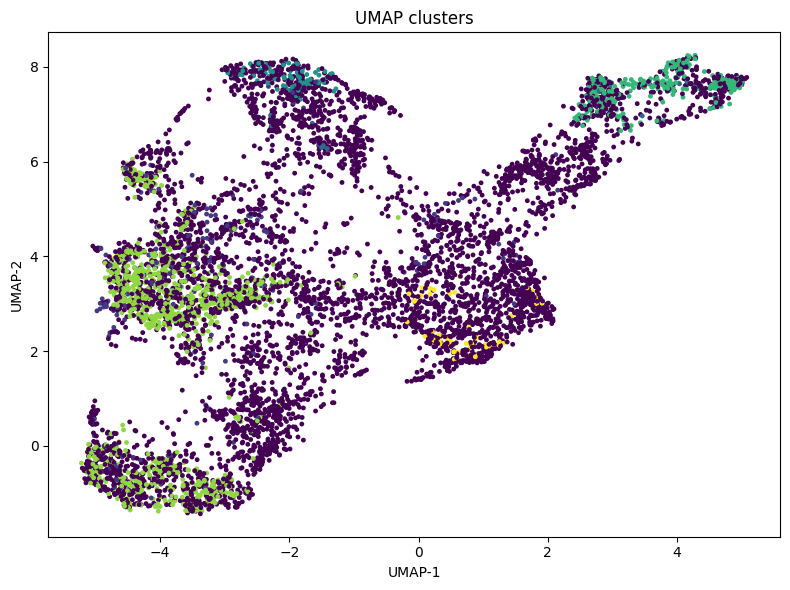

In [18]:
import matplotlib.pyplot as plt
from pathlib import Path

Path("../reports/figures").mkdir(parents=True, exist_ok=True)

plt.figure(figsize=(8, 6))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=use["cluster_id"], s=6)
plt.title("UMAP clusters")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.savefig("../reports/figures/umap_clusters.png", dpi=200)
plt.show()

In [19]:
dashboard.to_csv("../reports/artifacts/theme_dashboard_with_meta.csv", index=False)